# Импорт необходимых библиотек

In [62]:
import numpy as np, pandas as pd
import os
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import keras
from keras.applications import ResNet50, Xception, InceptionResNetV2
from skimage.io import imread
import pylab
from skimage.transform import rescale, resize, downscale_local_mean
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'pylab', 'resize', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
img_cols = 200
img_rows = 200
n_channels = 3
epochs = 5
batch_size = 16
train_samples = 2000
validation_samples = 800
path = '../popular_NN_weights/'
inshape = (img_cols, img_rows, n_channels)

## Предобученные сети

In [3]:
pretrained_models = {
    'xception': lambda: Xception(include_top=False, input_shape=inshape,  
                                 weights=path+'../popular_NN_weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'),
    'resnet50': lambda: ResNet50(include_top=False, input_shape=inshape, 
                                 weights=path+'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'),
    'inception':lambda: InceptionResNetV2(include_top=False, input_shape=inshape, 
                                          weights=path+'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
}

### Дообучаю сеть

Здесь я провела несколько экспериментов с разными предобученными сетями и разными гиперпараметрами в итоге остановилась на такой конфигурации. Так как качество на train и test значительно отличалось добавила еще регуляризацию и Dropout.

In [4]:
def get_model(name='inception'):
    base = pretrained_models[name]()
    inputs = [base.input]
    x = GlobalAveragePooling2D()(base.output)

    x = Dropout(0.5)(x)

    x = Dense(2, activation='softmax', 
              kernel_regularizer=keras.regularizers.l2(0.05),
              activity_regularizer=keras.regularizers.l1(0.05))(x)

    for l in base.layers:
        l.trainable = False

    return Model(inputs=inputs, outputs=x)

In [5]:
model = get_model('inception')

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(lr=0.001, decay=1e-6),
              metrics=['accuracy'])

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory='images/train',
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = validation_datagen.flow_from_directory(
    directory='images/test',
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_samples/batch_size,
    epochs=epochs,
    callbacks=[ModelCheckpoint('images/model/inception_plus.h5', monitor="val_acc", verbose=1, save_best_only=True)],
    validation_data=validation_gen,
    validation_steps=validation_samples/batch_size
)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/5
125/125 [==============================] - 126s 1s/step - loss: 1.4681 - acc: 0.7520 - val_loss: 1.2128 - val_acc: 0.9050
Epoch 2/5
125/125 [==============================] - 109s 868ms/step - loss: 1.3193 - acc: 0.8075 - val_loss: 1.2589 - val_acc: 0.8988
Epoch 3/5
125/125 [==============================] - 109s 869ms/step - loss: 1.2755 - acc: 0.8230 - val_loss: 1.1806 - val_acc: 0.9113
Epoch 4/5
125/125 [==============================] - 102s 818ms/step - loss: 1.2472 - acc: 0.8305 - val_loss: 1.1553 - val_acc: 0.9125
Epoch 5/5
125/125 [==============================] - 96s 766ms/step - loss: 1.2447 - acc: 0.8250 - val_loss: 1.1370 - val_acc: 0.9163


В итоге получилось достаточно неплохое качество. Но все также смущает большая разница между тестом и трейном, это может свидетельствовать о переобучении. Попробую запустить еще несколько эпох уменьшив learning rate 

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_samples/batch_size,
    epochs=3,
    callbacks=[ModelCheckpoint('images/model/inception_plus.h5', monitor="val_acc", verbose=1, save_best_only=True)],
    validation_data=validation_gen,
    validation_steps=validation_samples/batch_size
)

Epoch 1/3
125/125 [==============================] - 119s 956ms/step - loss: 1.2037 - acc: 0.8490 - val_loss: 1.1207 - val_acc: 0.9150

Epoch 00001: val_acc improved from -inf to 0.91500, saving model to images/model/inception_plus.h5
Epoch 2/3
125/125 [==============================] - 93s 744ms/step - loss: 1.1990 - acc: 0.8440 - val_loss: 1.1162 - val_acc: 0.9200

Epoch 00002: val_acc improved from 0.91500 to 0.92000, saving model to images/model/inception_plus.h5
Epoch 3/3
125/125 [==============================] - 105s 843ms/step - loss: 1.2049 - acc: 0.8420 - val_loss: 1.1135 - val_acc: 0.9175

Epoch 00003: val_acc did not improve from 0.92000


Качество не улучшается, попробую еще уменьшить lr

In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(lr=1e-5, decay=1e-6),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_samples/batch_size,
    epochs=3,
    callbacks=[ModelCheckpoint('images/model/inception_plus.h5', monitor="val_acc", verbose=1, save_best_only=True)],
    validation_data=validation_gen,
    validation_steps=validation_samples/batch_size
)

Epoch 1/3
125/125 [==============================] - 116s 925ms/step - loss: 1.2064 - acc: 0.8495 - val_loss: 1.1130 - val_acc: 0.9200

Epoch 00001: val_acc improved from -inf to 0.92000, saving model to images/model/inception_plus.h5
Epoch 2/3
125/125 [==============================] - 94s 753ms/step - loss: 1.2049 - acc: 0.8490 - val_loss: 1.1129 - val_acc: 0.9187

Epoch 00002: val_acc did not improve from 0.92000
Epoch 3/3
125/125 [==============================] - 92s 738ms/step - loss: 1.2041 - acc: 0.8470 - val_loss: 1.1128 - val_acc: 0.9175

Epoch 00003: val_acc did not improve from 0.92000


In [13]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(lr=1e-6, decay=1e-7),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_samples/batch_size,
    epochs=3,
    callbacks=[ModelCheckpoint('images/model/inception_plus.h5', monitor="val_acc", verbose=1, save_best_only=True)],
    validation_data=validation_gen,
    validation_steps=validation_samples/batch_size
)

Epoch 1/3
125/125 [==============================] - 111s 886ms/step - loss: 1.2008 - acc: 0.8460 - val_loss: 1.1127 - val_acc: 0.9175

Epoch 00001: val_acc improved from -inf to 0.91750, saving model to images/model/inception_plus.h5
Epoch 2/3
125/125 [==============================] - 97s 777ms/step - loss: 1.2050 - acc: 0.8475 - val_loss: 1.1127 - val_acc: 0.9175

Epoch 00002: val_acc did not improve from 0.91750
Epoch 3/3
125/125 [==============================] - 103s 822ms/step - loss: 1.1935 - acc: 0.8520 - val_loss: 1.1127 - val_acc: 0.9175

Epoch 00003: val_acc did not improve from 0.91750


Качество больше не меняется, посмотрим на лучший результат полученной модели

In [14]:
model.load_weights('images/model/inception_plus.h5')
score = model.evaluate_generator(
    generator=validation_gen,
    steps=validation_samples/batch_size
)

print("Best loss: {}".format(score[0]))
print("Best accuracy: {}".format(score[1]))

Best loss: 1.1127318549156189
Best accuracy: 0.9175


## Посмотрим пример работы классификатора на конкретных изображениях

Чтобы эмпирически оценить качество полученного алгоритма и убедиться в аддекватности его работы возьмем по несколько изображений из обучающей и тестовой выборок случайным образом и посмотрим на метки

In [137]:
rand_photo = np.random.randint(0,400,10)

In [142]:
im_dir = 'images/test/cat/'
ls_cat = np.array(os.listdir(im_dir))
rand_imgs = ls_cat[rand_photo]

In [143]:
im_dir_dogs = 'images/test/dog/'
ls_dog = np.array(os.listdir(im_dir_dogs))
rand_imgs_dog = ls_dog[rand_photo]

In [144]:
full_names = list(map(lambda x: im_dir+x, np.array(rand_imgs)))
full_names_dog = list(map(lambda x: im_dir_dogs+x, np.array(rand_imgs_dog)))

In [145]:
image = imread(im_dir+rand_imgs[0])
rand_imgs = list(map(imread, full_names))
rand_imgs_dog = list(map(imread, full_names_dog))

In [168]:
image.shape

(321, 480, 3)

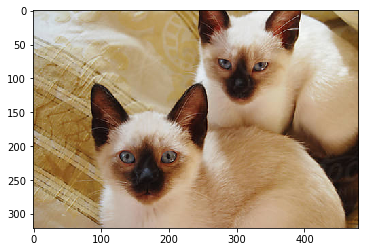

In [147]:
pylab.imshow(image);

In [174]:
ls = np.array(list(map(resize, rand_imgs, np.full((10,3),(200,200, 3)))))
ls_dogs = np.array(list(map(resize, rand_imgs_dog, np.full((10,3),(200,200, 3)))))
answ = model.predict(ls)
answ_dogs = model.predict(ls_dogs)

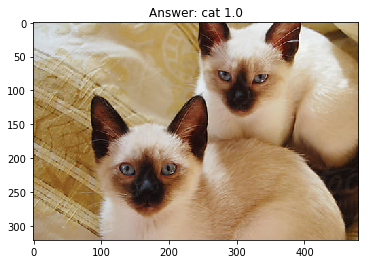

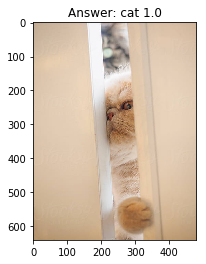

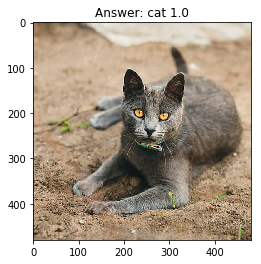

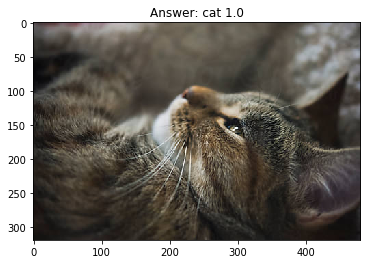

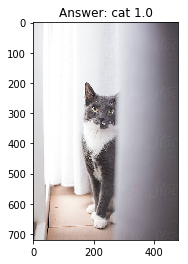

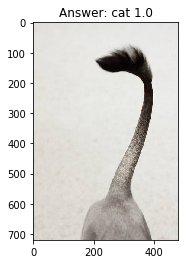

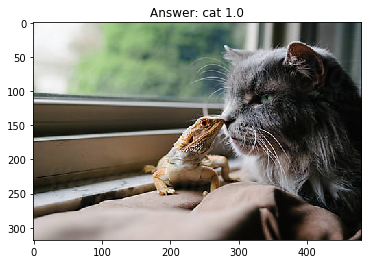

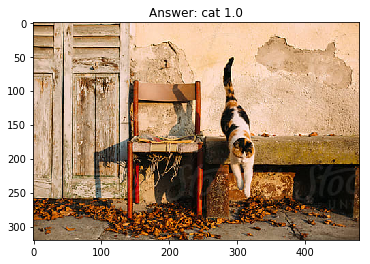

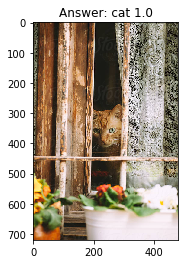

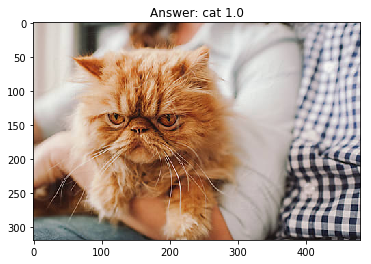

In [173]:
for img, answer in zip((list(rand_imgs)), (answ)):
    if answer[0]>0.5:
        pylab.title('Answer: dog', str(answer[0]))
    else:
        pylab.title('Answer: cat '+ str(1 - answer[0]))
    pylab.imshow(img) 
    plt.show()